# TEPs Output Analysis

This notebook analyzes the results of a TEPs run that includes 2017-2018 data - *proposed* - with those performed using TEPs "out-of-the-box" - *recalc* - and those provided directly by Arman - *baseline*.  They're located in `VolumeModel\TEPS-EEDrun`, `VolumeModel\TEPS-exerun` and `VolumeModel\TEPS-onedrive`, respectively.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats import multitest

In [2]:
import configparser
import pathlib
import psycopg2

config = configparser.ConfigParser()
config.read(pathlib.Path.home().joinpath('.charlesconfig').as_posix());
postgres_settings = config['POSTGRES']

In [3]:
path_baseline = "/mnt/c/Users/czhu5/Documents/VolumeModel/TEPS-onedrive/aadt_output_files/"
path_recalc = "/mnt/c/Users/czhu5/Documents/VolumeModel/TEPS-exerun/aadt_output_files/"
path_proposed = "/mnt/c/Users/czhu5/Documents/VolumeModel/TEPS-EEDrun/aadt_output_files/"

In [4]:
centreline_lengths = pd.read_csv(
    "/mnt/c/Users/czhu5/Documents/VolumeModel/TEPS-EEDrun/KCOUNT/RMsma_2km_pos/centreline_length.csv")

## Z-Score distribution comparison

We'll treat each AADT estimates as $\mathcal{N}(\mu, \Sigma)$, where $\mu$ is the AADT reported and $\Sigma$ can be back-calculated using the 95% CIs.

Recall that the difference of two normally distributed RVs is:

$$
\mathcal{N}(\mu_1 \Sigma_1) - \mathcal{N}(\mu_2, \Sigma_2) \sim \mathcal{N}(\mu_1 - \mu_2, \Sigma_1 + \Sigma_2)
$$

In [5]:
twosigma = stats.norm.ppf(0.975, loc=0, scale=1)

def read_csv(path, year):
    df = pd.read_csv(path + "final_aadt_{0}.csv".format(year), usecols=list(range(5)))
    df.columns = [x.strip() for x in df.columns.values]
    df.loc[df['LowerBound'] == 9999., 'LowerBound'] = np.nan
    df.loc[df['UpperBound'] == 9999., 'UpperBound'] = np.nan
    # LowerBound and UpperBound are symmetric.
    df['stdev'] = (df['UpperBound'] - df['aadt']) / twosigma
    return df

In [6]:
twosigma = stats.norm.ppf(0.975, loc=0, scale=1)

def z_dist(path1, path2, year, title):
    # See also https://www.sciencedirect.com/science/article/pii/S0741521402000307
    
    df1 = read_csv(path1, year).dropna()
    df2 = read_csv(path2, year).dropna()
    
    df = pd.merge(df1, df2, how='inner', on=('centreline_id', 'dir_bin'),
                  suffixes=('_1', '_2'))

    df['aadt_difference'] = df['aadt_1'].values - df['aadt_2'].values
    df['difference_stdev'] = (df['stdev_1'].values**2 + df['stdev_2'].values**2)**0.5
    # Z = (val - mean) / std, of course.
    df['z_score'] = df['aadt_difference'].values / df['difference_stdev'].values
    # sf is Survival function
    # https://stackoverflow.com/questions/3496656/convert-z-score-z-value-standard-score-to-p-value-for-normal-distribution-in
    df['p_val'] = stats.norm.sf(abs(df['z_score'].values), loc=0, scale=1)

    zvals = np.linspace(-3, 3, 1000)
    pdfvals = stats.norm.pdf(zvals)

    fig, ax = plt.subplots(figsize=(12, 8))
    ax.plot(zvals, pdfvals, lw=3)
    ax.hist(df['z_score'].values, bins=100, range=(-3., 3.), density=True)
    ax.set_xlim([-2., 2.]);
    ax.set_xlabel("Z-Score", fontsize=16)
    ax.tick_params(axis='both', which='both', labelsize=14)
    ax.set_ylabel("PDF", fontsize=16)
    ax.set_title(title, fontsize=18)
    
    # Return AADT estimates where we can reject the null hypothesis that the two
    # datasets are drawn from the same distribution.  Use Holm-Sidak adjusted
    # p-values.
    # https://www.statsmodels.org/stable/generated/statsmodels.stats.multitest.multipletests.html
    reject, pvals_corrected, alphacSidak, alphacBonf = multitest.multipletests(df['p_val'].values, alpha=0.05)
    df['p_val_HScorrected'] = pvals_corrected
    
    return df.loc[reject, :]

### Distribution between baseline and recalculted

This checks whether the AADTs I recalculated with Arman's help in October 2019 are statistically distinguishable from those in Arman's OneDrive.

,centreline_id,dir_bin,aadt_1,LowerBound_1,UpperBound_1,stdev_1,aadt_2,LowerBound_2,UpperBound_2,stdev_2,aadt_difference,difference_stdev,z_score,p_val,p_val_HScorrected
453,1544,1,4838.774178,3924.613718,5752.934638,466.416968,2420.507198,2081.328614,2759.685782,173.053478,2418.266980,497.485974,4.860975,5.840445e-07,1.844994e-02
533,1723,1,1865.957564,1652.296116,2079.619012,109.012946,5156.596149,4248.945573,6064.246724,463.095538,-3290.638585,475.753402,-6.916690,2.311598e-12,7.379537e-08
1421,103384,1,1787.004391,1559.887684,2014.121098,115.878000,5750.505982,4930.988226,6570.023737,418.128987,-3963.501591,433.888880,-9.134831,3.275451e-20,0.000000e+00
1789,104273,1,4867.942032,3874.003110,5861.880955,507.121014,2050.806030,1723.093719,2378.518341,167.203231,2817.136002,533.974384,5.275789,6.609318e-08,2.106151e-03
3009,106797,1,12014.996720,10780.862890,13249.130550,629.671688,2166.302884,1944.411474,2388.194294,113.211983,9848.693836,639.768230,15.394159,8.956924e-54,0.000000e+00


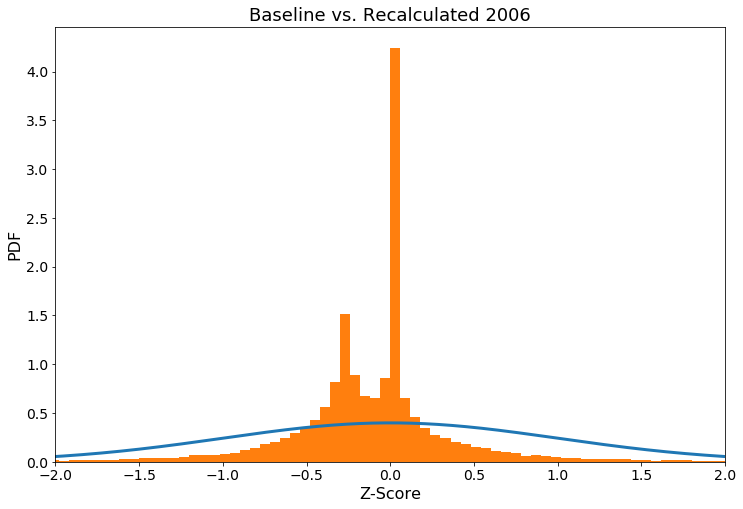

In [7]:
rejects = z_dist(path_baseline, path_recalc, 2006, "Baseline vs. Recalculated 2006")
rejects.head()

,centreline_id,dir_bin,aadt_1,LowerBound_1,UpperBound_1,stdev_1,aadt_2,LowerBound_2,UpperBound_2,stdev_2,aadt_difference,difference_stdev,z_score,p_val,p_val_HScorrected


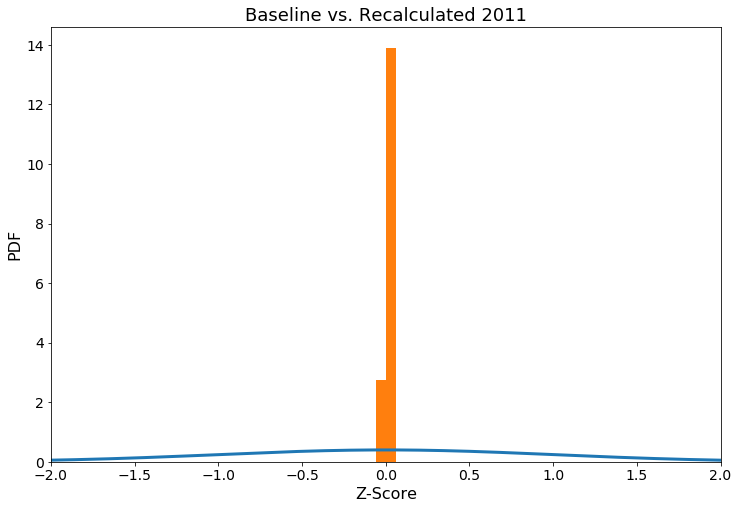

In [8]:
rejects = z_dist(path_baseline, path_recalc, 2011, "Baseline vs. Recalculated 2011")
rejects.head()

,centreline_id,dir_bin,aadt_1,LowerBound_1,UpperBound_1,stdev_1,aadt_2,LowerBound_2,UpperBound_2,stdev_2,aadt_difference,difference_stdev,z_score,p_val,p_val_HScorrected
5681,436282,-1,7360.498104,6067.442934,8653.553274,659.734148,2066.981559,1713.142143,2420.820975,180.533632,5293.516545,683.989429,7.739179,5.003046e-15,1.595973e-10
6779,439188,-1,1665.089279,1291.352551,2038.826007,190.685508,5216.361729,3953.506414,6479.217044,644.325776,-3551.272450,671.949900,-5.285026,6.284358e-08,2.004333e-03
6878,439489,-1,5930.217257,4971.797009,6888.637504,488.998907,2140.995559,1857.626348,2424.364770,144.578785,3789.221698,509.924462,7.430947,5.391142e-14,1.723381e-09
6879,439489,1,6411.868154,5538.153079,7285.583229,445.781189,2111.945852,1826.988408,2396.903296,145.389123,4299.922302,468.891102,9.170407,2.356179e-20,0.000000e+00
8541,444150,1,19650.773980,18778.506100,20523.041850,445.042805,2625.475859,2546.698325,2704.253393,40.193358,17025.298121,446.854120,38.100349,0.000000e+00,0.000000e+00


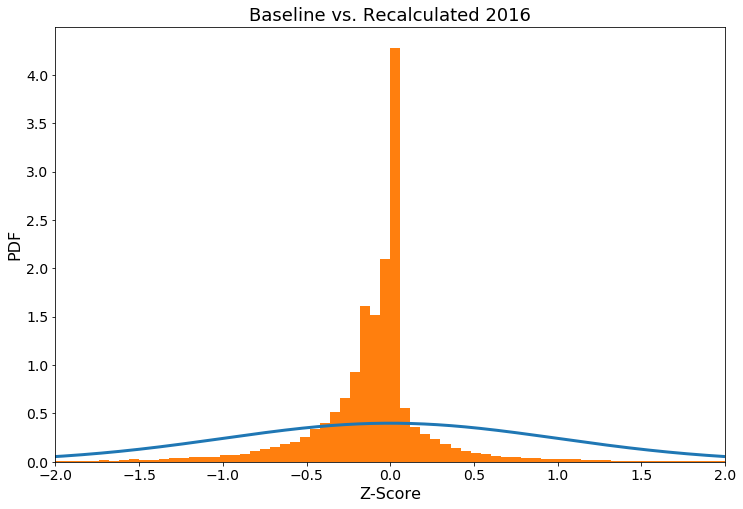

In [9]:
rejects = z_dist(path_baseline, path_recalc, 2016, "Baseline vs. Recalculated 2016")
rejects.head()

There's definitely a tail of values that have extremely large z-scores.  If we assume there's a degree of stochasticity to TEPs-I's estimates (though why would there be?), then this is to be expected.  The distribution is obviously not gaussian, however, being much more narrowly peaked.

Why are the differences so small for 2011?  I honestly don't know - it could be some internal baseline in TEPs is hardcoded to 2011 (though it does look like the year of analysis is passed from the GUI to all functions).  It's also possible that the run on Arman's OneDrive uses individual station growth rates but the code he handed over averages growth.  We'll see below, however that there are no systematic offsets between the sets of predictions for other years, which I'd expect if the growth rates are being calculated differently.  Since I don't fully understand the source of stochasticity in TEPs at all, I'm at a loss.

### Distribution between recalculated and proposed

This checks whether including the 2017-2018 count data significantly alters TEPs-I's predictions.

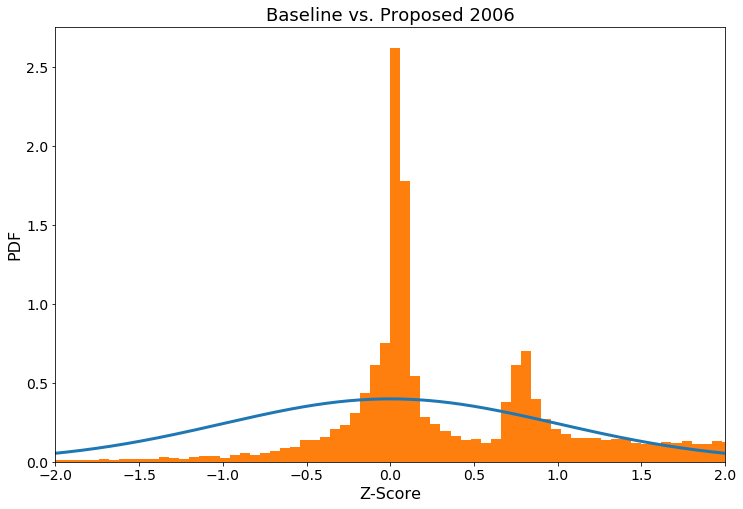

In [10]:
rejects = z_dist(path_recalc, path_proposed, 2006, "Baseline vs. Proposed 2006")

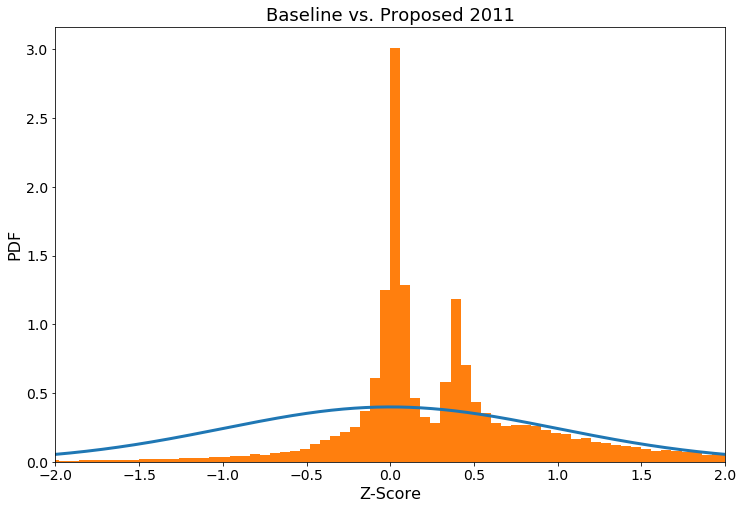

In [11]:
rejects = z_dist(path_recalc, path_proposed, 2011, "Baseline vs. Proposed 2011")

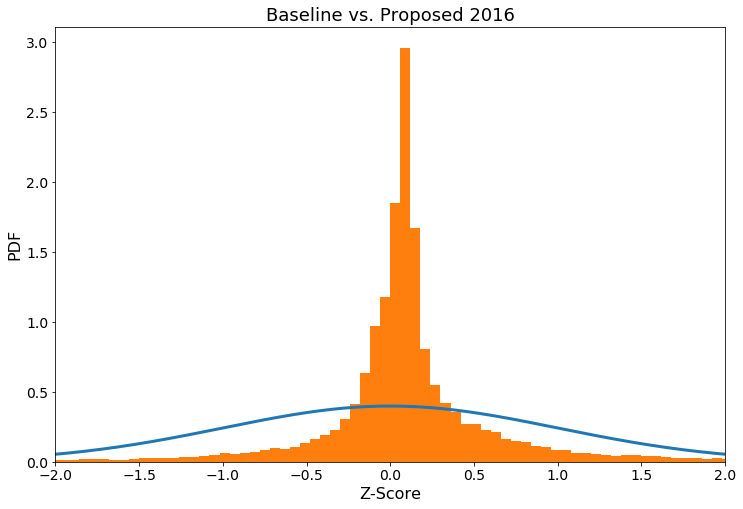

In [12]:
rejects = z_dist(path_recalc, path_proposed, 2016, "Baseline vs. Proposed 2016")

Yup, significantly different - notice that peak at $Z \approx 0.5 - 1$!  This second peak indicates that some fraction of AADT estimates is systematically offset from Arman's original run.  It is likely due to a new supply of permanent count stations (or years) available from 2017 and 2018.  Unless I missed a critical part of how TEPs works, it's still averaging all the growth rates together, in which case we would expect the entire peak to move rather than a second peak budding off.  Therefore the second peak comes from STTCs being assigned to different PTCs than they were in Arman's run.

## Baseline vs recalc & proposed across all years

Now we'll look at the absolute and absolute fractional deviation between predicted AADTs from Arman's OneDrive `baseline` and both my recalculated ones and my `proposed` ones that includes 2017-2018 data.

In [13]:
import matplotlib.ticker as mtk

def x_dist(path1, path2, year):
    # See also https://www.sciencedirect.com/science/article/pii/S0741521402000307
    
    df1 = read_csv(path1, year).dropna()
    df2 = read_csv(path2, year).dropna()
    
    df = pd.merge(df1, df2, how='inner', on=('centreline_id', 'dir_bin'),
                  suffixes=('_1', '_2'))

    df['aadt_difference'] = df['aadt_1'].values - df['aadt_2'].values
    
    df['aadt_percent_difference'] = abs(df['aadt_difference']) / df['aadt_1']

    return df

def multiyear_deviation_diagnostic(path_1, path_2, xlabel, ylabel):
    fig1, axs1 = plt.subplots(3, 4, figsize=(15, 12))
    fig1.subplots_adjust(left=0.1, right=0.92, bottom=0.1, top=0.925)

    fig2, axs2 = plt.subplots(3, 4, figsize=(15, 12))
    fig2.subplots_adjust(left=0.1, right=0.92, bottom=0.1, top=0.925)

    for idx, year in enumerate(range(2006, 2017)):
        i = idx // 4
        j = idx % 4

        dft = x_dist(path_1, path_2, year)

        maxval = max([dft['aadt_1'].max(), dft['aadt_2'].max()])
        axs1[i, j].plot([0, maxval], [0, maxval], 'b--', lw=1)
        axs1[i, j].plot(dft['aadt_1'], dft['aadt_2'], 'ro', ms=1)
        axs1[i, j].set(xlim=[0, maxval], ylim=[0, maxval], aspect=1, title=str(year))
        axs1[i, j].axes.ticklabel_format(axis='both', style='sci', scilimits=(0, 0))
        axs1[i, j].xaxis.set_major_locator(mtk.MultipleLocator(2e4))
        axs1[i, j].yaxis.set_major_locator(mtk.MultipleLocator(2e4))

        axs2[i, j].plot(dft['aadt_1'], dft['aadt_percent_difference'], 'bo', ms=1)
        axs2[i, j].axes.ticklabel_format(axis='x', style='sci', scilimits=(0, 0))
        axs2[i, j].set(yscale='log', title=str(year), ylim=[1e-4, 1e1])

    fig1.delaxes(axs1[2, 3])
    fig2.delaxes(axs2[2, 3])

    fig1.text(0.5, 0.05, xlabel, ha='center', fontsize=14)
    fig1.text(0.05, 0.5, ylabel, va='center', rotation='vertical', fontsize=14)
    fig1.suptitle("{0} vs. {1} Values".format(ylabel, xlabel), fontsize=18)

    fig2.text(0.5, 0.05, xlabel, ha='center', fontsize=14)
    fig2.text(0.05, 0.5, 'Fractional Deviation', va='center', rotation='vertical', fontsize=14)
    fig2.suptitle("{0} vs. {1} Absolute Fractional Error".format(ylabel, xlabel), fontsize=18)

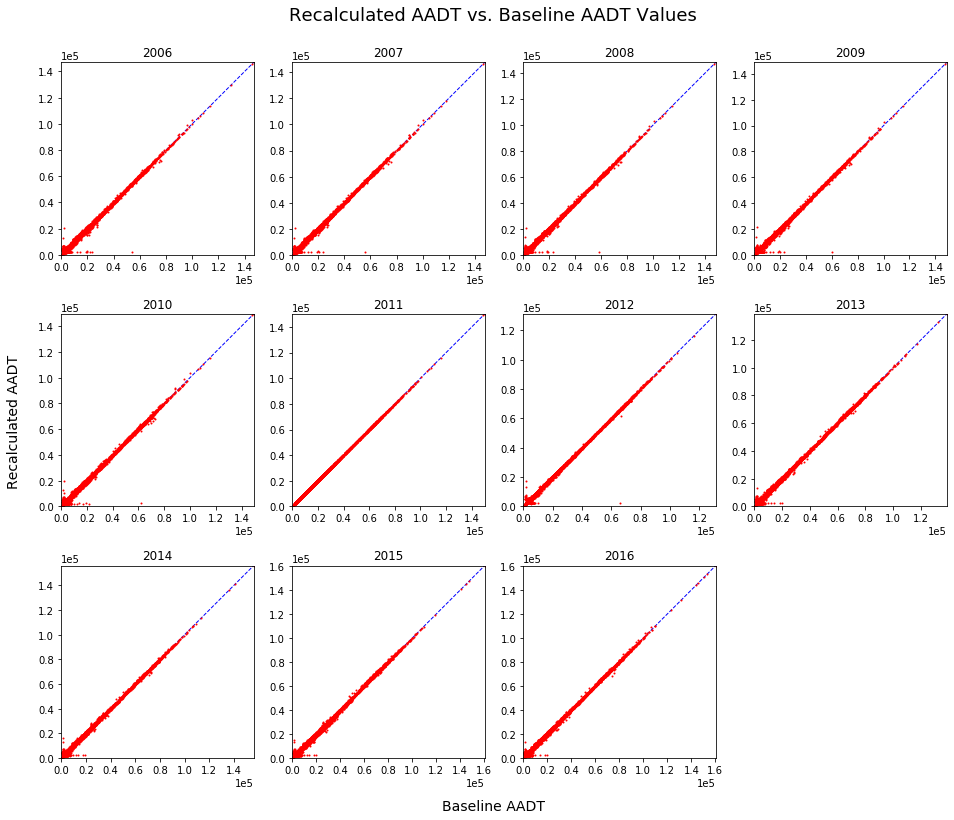

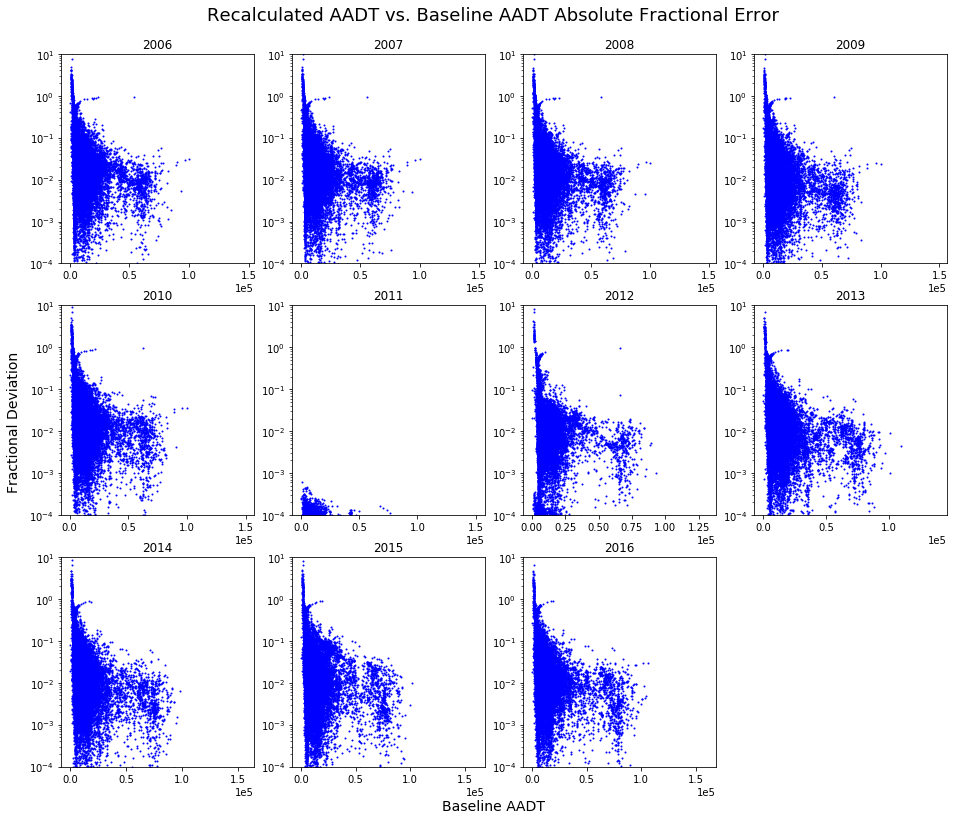

In [14]:
multiyear_deviation_diagnostic(path_baseline, path_recalc, "Baseline AADT", "Recalculated AADT")

No obvious systematic offsets exist at different AADT values between baseline and recalculated.  The increase in high-Z values looks to be due to outliers, particularly at low AADT.  This means the trouble may stem from LSVR (or maybe PRTCS does a bad job of predicting low AADT values on streets, which propagates to KCOUNT and LSVR).

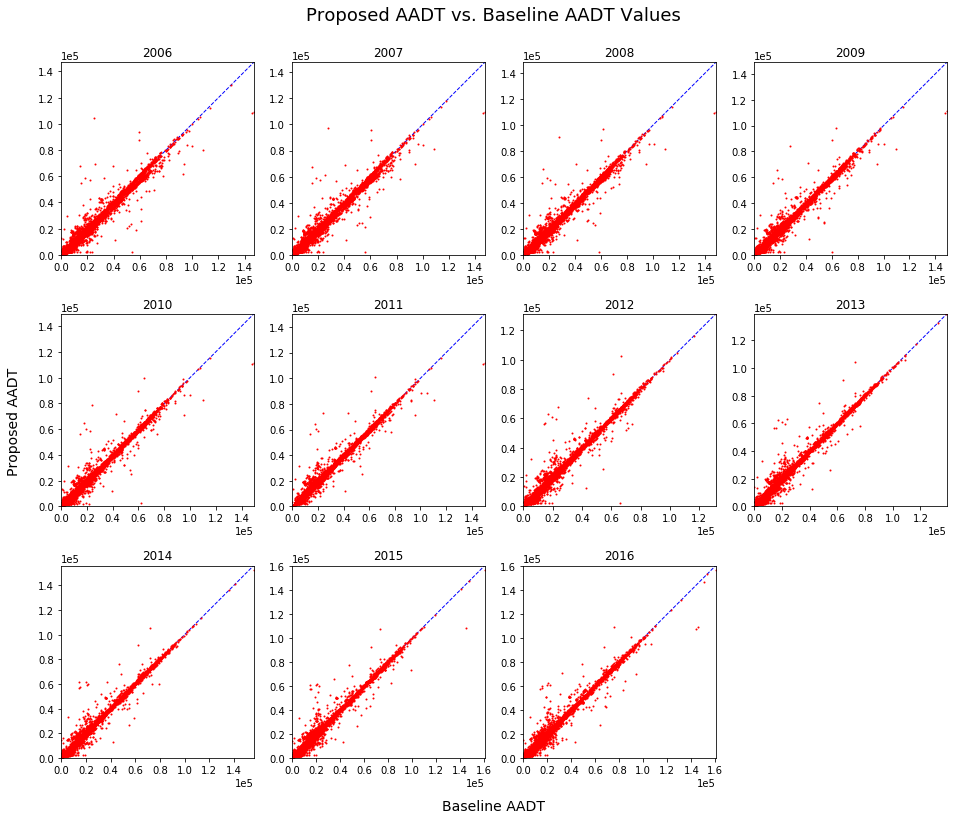

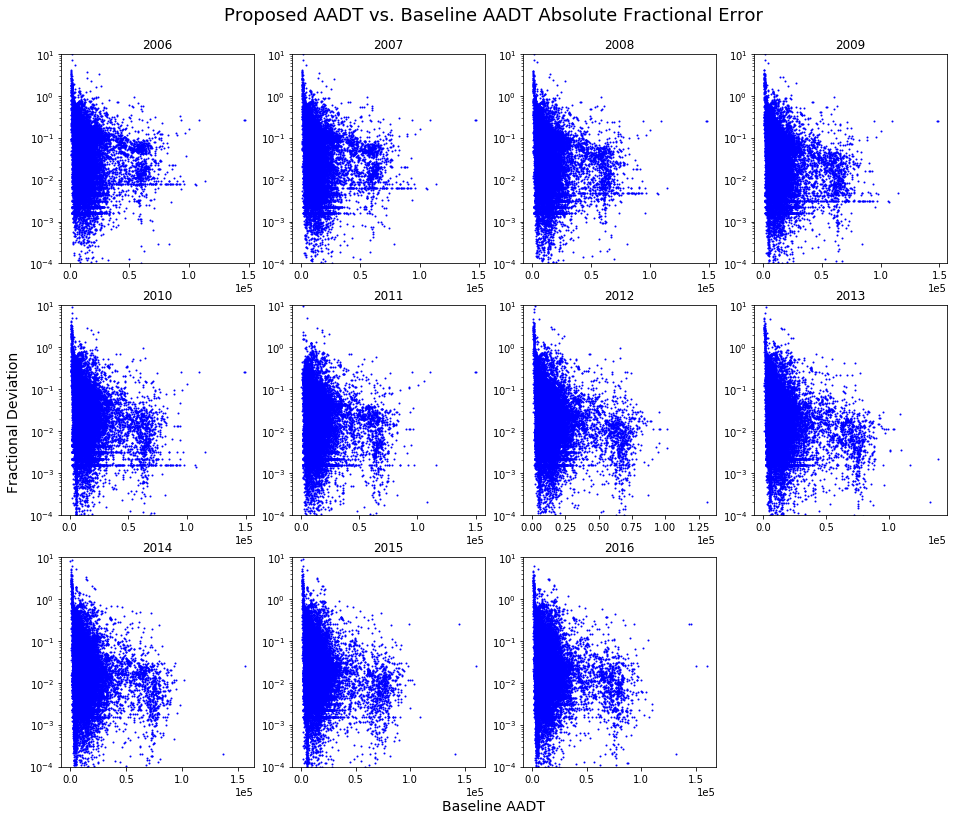

In [15]:
multiyear_deviation_diagnostic(path_baseline, path_proposed, "Baseline AADT", "Proposed AADT")

A similar pattern exists between baseline and proposed.  Errors at extremely large AADTs are typically at the 10% level while there's a tail of 1000% error for very small AADTs.  The secondary peak of z-scores is evident in earlier year fractional deviation plots.  Around 2006, there appears to be more points congregated at $10^{-1}$, particularly at small AADTs, than in 2016.  This 10% error trend is harder to see in Values plot, since the entire cloud of points is only shifting slightly.

## Baseline vs proposed map

I also want to check that these errors are not geospatially clustered.  We can do this by plotting the fractional deviation on a map for a given year:

In [16]:
import geopandas as gpd
import matplotlib.colors as colors
import matplotlib as mpl

with psycopg2.connect(database='bigdata', **postgres_settings) as db_con:
    # Read in data.
    sql_query = ("SELECT centreline_id, fcode_desc, geom, lon, lat,"
                 "ST_SetSRID(ST_MakePoint(lon, lat), 4326) point_geom "
                 "FROM czhu.btp_centreline_lonlat")
    ctrline_geoms = gpd.read_postgis(sql_query, db_con)
    ctrline_geoms['centreline_id'] = ctrline_geoms['centreline_id'].astype(int)

def map_fractional_err(path_1, path_2, year, title, filename=None):
    dft = x_dist(path_1, path_2, year)
    dft = pd.merge(ctrline_geoms[['centreline_id', 'geom']],
                   dft[['centreline_id', 'aadt_percent_difference']],
                   how='inner', on='centreline_id')
    dft = gpd.GeoDataFrame(dft, crs={'init': 'epsg:4326'}, geometry='geom')

    fig = plt.figure(figsize=(14, 8))
    fig.patch.set_facecolor('#1c1c1c')
    ax = fig.add_axes([0., 0., 0.8, 1.])
    ax.axis('off')
    ax.set_title(title, fontsize=14, color='w')
    # Not absolute minimum, for more color dynamics.
    im = dft.to_crs(epsg=3857).plot(column='aadt_percent_difference', ax=ax,
                                    cmap='viridis', norm=colors.LogNorm(),
                                    vmin=1e-2, vmax=1.)
    cbax = fig.add_axes([0.8, 0., 0.025, 1.])
    cb1 = mpl.colorbar.ColorbarBase(cbax, cmap=mpl.cm.viridis,
                                    norm=colors.LogNorm(vmin=1e-2, vmax=1.),
                                    orientation='vertical')
    cb1.ax.tick_params(axis='both', which='both', labelsize=12, pad=15, length=10,
                       width=1.5, labelcolor='white', colors='white')
    cb1.ax.set_ylabel('Fractional AADT Error', fontsize=15, color='white')

    if filename is not None:
        # Output to QGIS to check local continuity of error estimates.
        dft.to_file(filename)

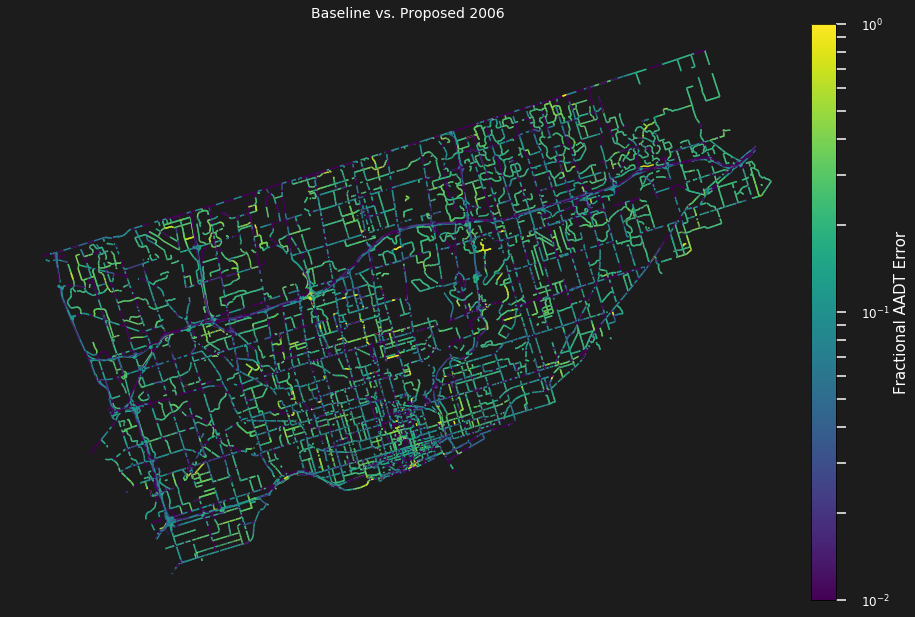

In [17]:
map_fractional_err(path_baseline, path_proposed, 2006, "Baseline vs. Proposed 2006")

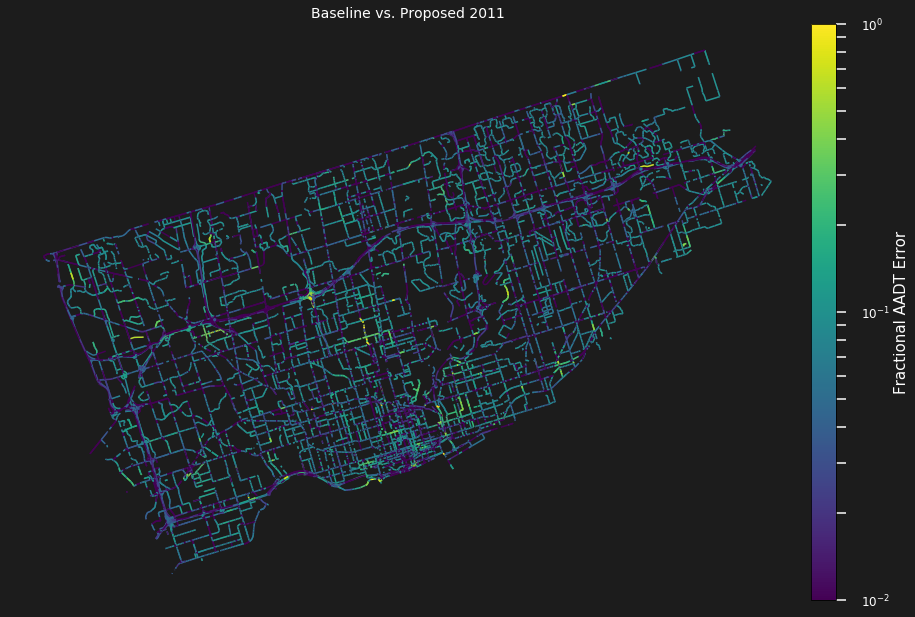

In [18]:
map_fractional_err(path_baseline, path_proposed, 2011, "Baseline vs. Proposed 2011")

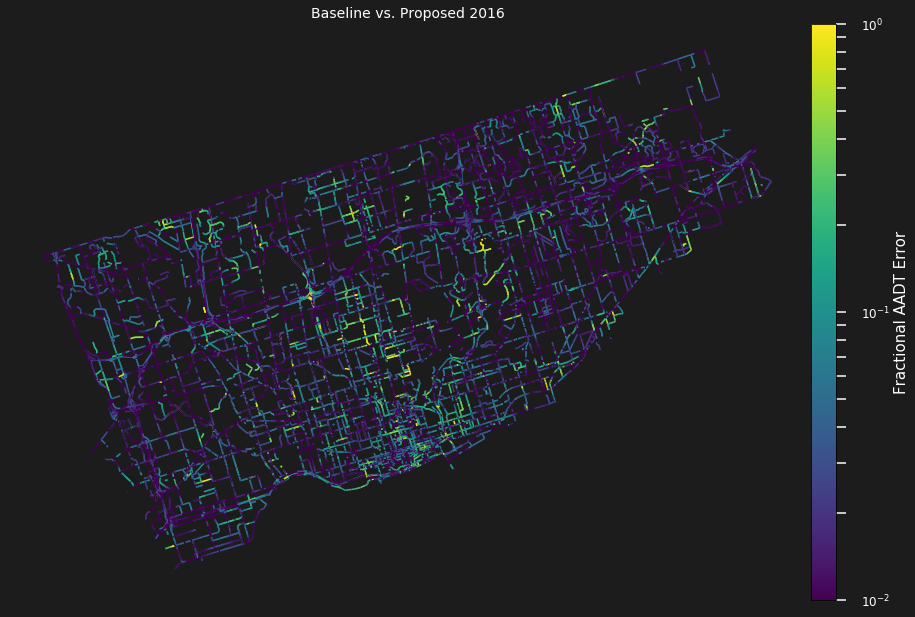

In [19]:
map_fractional_err(path_baseline, path_proposed, 2016, "Baseline vs. Proposed 2016", filename='TEPs_networkerr.shp')

This is annoying - the errors ARE spatially clustered.  Looks like eg. the area around Eglinton and Avenue, St. Clair & Mt. Pleasant, and the area around Queen E. and the DVP, are all hotspots.

## Comparing year-on-year citywide annually averaged daily VKT

We can estimate citywide VKT by multiplying AADT with road length, and summing up all segment-level VKTs.  How do baseline, recalc and proposed compare in that case?

In [20]:
def citywide_aavkt(path, year, getraw=False):
    df = read_csv(path, year)
    df = pd.merge(df[['centreline_id', 'dir_bin', 'aadt']],
                  centreline_lengths[['centreline', 'shape_leng_meter']],
                  how='left', left_on='centreline_id', right_on='centreline')
    df['aavkt'] = df['aadt'].values * df['shape_leng_meter'].values / 1000.
    if getraw:
        return df
    return df['aavkt'].sum()

In [21]:
baseline_aavkt = [citywide_aavkt(path_baseline, year) for year in range(2006, 2017)]
baseline_aavkt += [np.nan, np.nan]
recalc_aavkt = [citywide_aavkt(path_recalc, year) for year in range(2006, 2017)]
recalc_aavkt += [np.nan, np.nan]
proposed_aavkt = [citywide_aavkt(path_proposed, year) for year in range(2006, 2019)]
df_aavkt = pd.DataFrame({'baseline': baseline_aavkt, 'recalculated': recalc_aavkt,
                         'proposed': proposed_aavkt}, index=range(2006, 2019))

In [22]:
df_aavkt

,baseline,recalculated,proposed
2006,6.128539e+07,6.144856e+07,5.920086e+07
2007,6.196414e+07,6.213839e+07,6.001631e+07
2008,6.220374e+07,6.229390e+07,6.061885e+07
2009,6.339635e+07,6.333757e+07,6.219162e+07
2010,6.426012e+07,6.431318e+07,6.313190e+07
2011,6.503512e+07,6.503453e+07,6.402116e+07
2012,6.640053e+07,6.624817e+07,6.594074e+07
2013,6.811254e+07,6.829961e+07,6.792996e+07
2014,6.756172e+07,6.770710e+07,6.764927e+07
2015,6.897790e+07,6.889761e+07,6.862255e+07


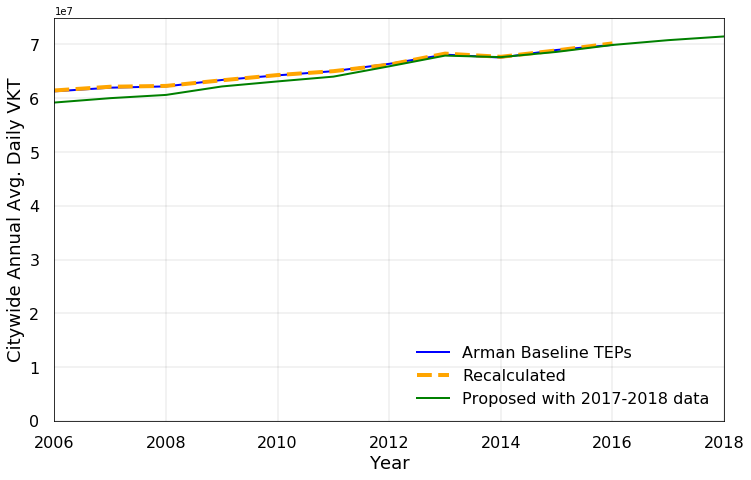

In [25]:
fig, ax = plt.subplots(figsize=(12, 8))
fig.subplots_adjust(bottom=0.2, top=0.9)
df_aavkt.plot(ax=ax, y='baseline', label='Arman Baseline TEPs', lw=2, color='blue')
df_aavkt.plot(ax=ax, y='recalculated', label='Recalculated', ls='--', lw=4, color='orange')
df_aavkt.plot(ax=ax, y='proposed', label='Proposed with 2017-2018 data', lw=2, color='green')
ax.grid(color='k', linestyle='-', linewidth=0.1)
ax.set_ylim([0, 7.5e7])
ax.set_xlabel("Year", fontsize=18)
ax.set_ylabel("Citywide Annual Avg. Daily VKT", fontsize=18)
ax.tick_params(axis='both', which='both', labelsize=16, length=0, pad=15)
ax.legend(loc=4, facecolor='white', frameon=False, fontsize=16);

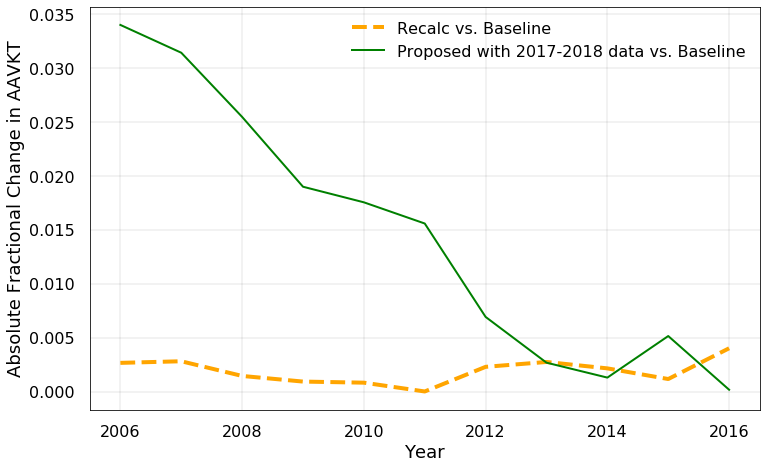

In [27]:
fig, ax = plt.subplots(figsize=(12, 8))
fig.subplots_adjust(bottom=0.2, top=0.9)
ax.plot(df_aavkt.index.values, abs(df_aavkt['recalculated'].values - df_aavkt['baseline'].values) / df_aavkt['baseline'].values,
        label='Recalc vs. Baseline', color='orange', lw=4, ls='--')
ax.plot(df_aavkt.index.values, abs(df_aavkt['proposed'].values - df_aavkt['baseline'].values) / df_aavkt['baseline'].values,
        label='Proposed with 2017-2018 data vs. Baseline', color='green', lw=2)
ax.grid(color='k', linestyle='-', linewidth=0.1)
ax.set_xlabel("Year", fontsize=18)
ax.set_ylabel("Absolute Fractional Change in AAVKT", fontsize=18)
ax.tick_params(axis='both', which='both', labelsize=16, length=0, pad=15)
ax.legend(loc=1, facecolor='white', frameon=False, fontsize=16);

The citywide averages are very close to one another!  The recalculated data is essentially identical in the aggregate to the baseline, deviating by less than 0.5% for any given year.  The proposed, which includes 2017-2018 data, diverges less and less significantly as we approach 2016, where the error is also around 0.5%.